In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

DM = Dispersion Measure
SNR = Signal to Noise Ratio

In [3]:
ps = pd.read_csv('C:\data\pulsarstars.csv')
#for colab
#ps = pd.read_csv('https://github.com/DoctorDroid/Build2/blob/master/pulsarstars.csv')
ps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


## Clean. No null values and all of the data is numeric


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

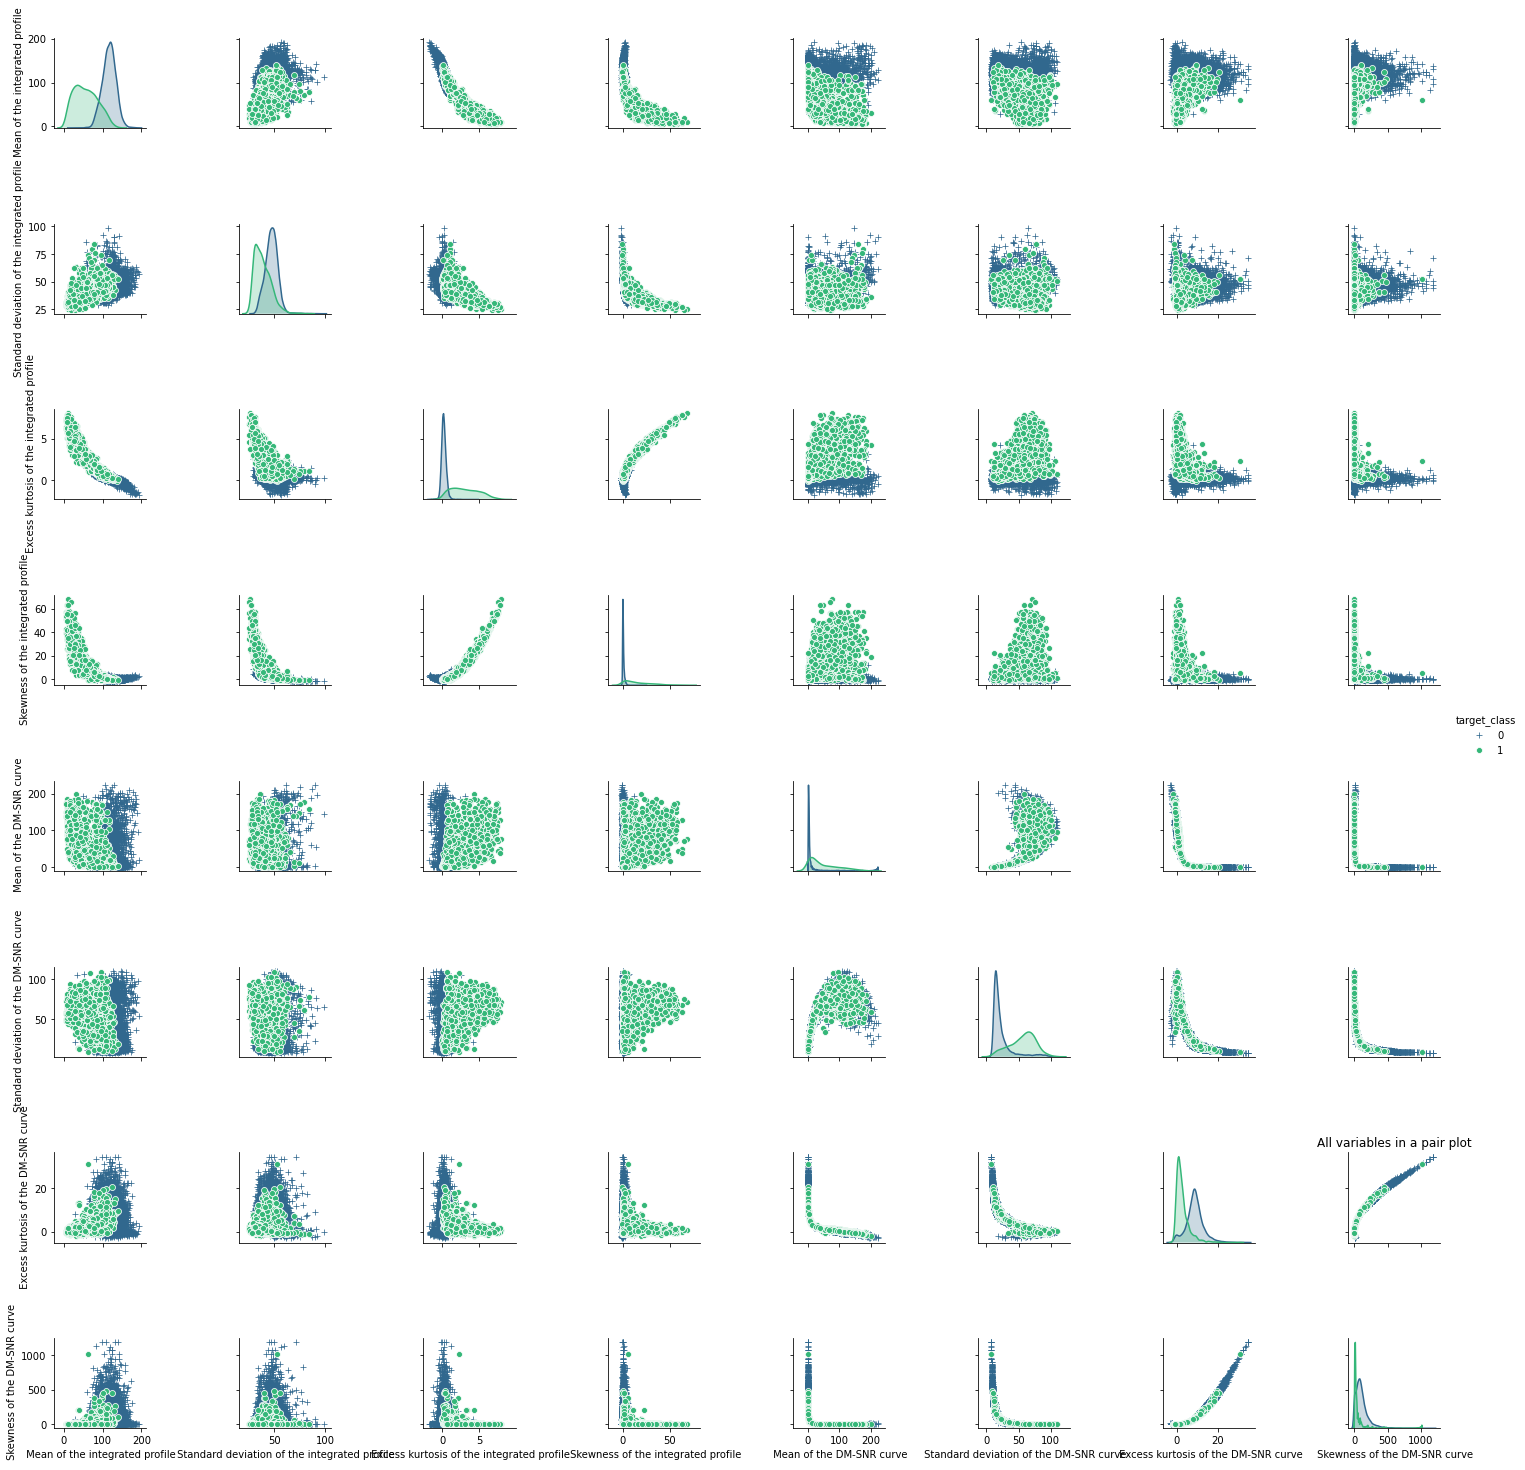

In [4]:
g1 = sns.pairplot(ps, hue = 'target_class',markers=["+", "o"],palette= 'viridis')
plt.title("All variables in a pair plot")
plt.tight_layout

### On to splitting the data into train/validate/and test sets

In [5]:
# Setting aside a sample of the data for testing.
# this portion will not be "known" during the model adjustment process.
train, test = train_test_split(ps,test_size=0.10, 
                              stratify=ps['target_class'],
                               random_state= 17)

In [6]:
# Separating the remaining data into training and validation sets.
#this allows me to tweak my model to perform at it's best before testing it on unknown data. 
train, val = train_test_split(train,test_size=0.20, 
                              stratify=train['target_class'],
                               random_state= 17)

In [7]:
train.shape,val.shape,test.shape

((12886, 9), (3222, 9), (1790, 9))

## To prove the similar distribuition over training, validation, and testing sets. 

This is accomplished by using the 'stratify' argument while splitting the data.

In [8]:
train['target_class'].value_counts(normalize=True),val['target_class'].value_counts(normalize=True),test['target_class'].value_counts(normalize=True)

(0    0.908428
 1    0.091572
 Name: target_class, dtype: float64,
 0    0.908442
 1    0.091558
 Name: target_class, dtype: float64,
 0    0.90838
 1    0.09162
 Name: target_class, dtype: float64)

## Solid.
###  If I just built a model that always reporterd '0' (non-pulsar star) it would be correct about 90.8% of the time (our baseline accuracy). This may be dificult to improve upon, but I enjoy a challenge!
### Now to separate our data into X feature matrices and y target vectors.

In [9]:
target = 'target_class'
features = ps.columns.drop(target)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

## Now to initialize my first model. I'll start with a Random Forrest Regressor

In [46]:
model0 = RandomForestRegressor(random_state=13,     # Random seed
                               
                               n_jobs=-1,           # -1 = max jobs my processing power can handle at once

                               n_estimators= 91,    # the number of decision trees the model may 
                                                    # create before taking a consensus 
                                
                               max_depth= 22)       # the max number of decisions to determine each vote

# Fit on train, score on val
model0.fit(X_train, y_train)
print('Validation Accuracy', model0.score(X_val, y_val))

Validation Accuracy 0.8039317754042418


# This model is not an improvement on my baseline accuracy.

## Now to initialize my first classification model. I am going with a Random Forrest Classifier. This type of model tends to out perform the rest of the models In my arsenal on classification tasks. 

In [48]:
model = RandomForestClassifier(random_state=13,     # Random seed to select the same  
                               n_jobs=-1,           # max jobs my processing power can handle at once

                               n_estimators= 91,    # the number of decision trees the model may 
                                                    # create before taking a consensus 
                                
                               max_depth= 22)       # the max number of decisions to determine each vote

# Fit on train, score on val
model.fit(X_train, y_train)
print('Validation Accuracy', model.score(X_val, y_val))

Validation Accuracy 0.9798261949099938


### After a few iterations, tweaking the hyperperameters lower and higher, I found the sweet spot of this models performance capabilities. Nearly 98% accurate is a better than expected result.
## Still I'll try for better before testing.
(I'd love to see another season of 'Lost in Space' , but I wouldn't want to be responsible for the reality-show version's release)
## More metrics before adding any new hyperparameters to my model or tuning my current ones. 


# Confusion Matrix

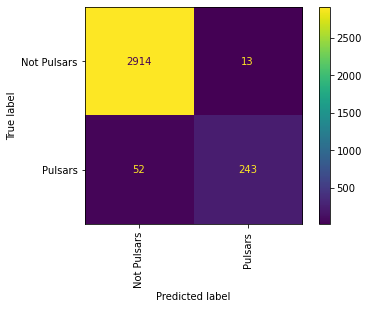

In [49]:
plot_confusion_matrix(model, X_val, y_val, values_format='.0f', xticks_rotation='vertical',display_labels=('Not Pulsars', 'Pulsars'))

# Probabilities as a Distibution plot

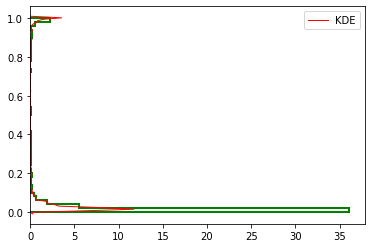

In [50]:
y_pred_proba = model.predict_proba(X_val)[:, 1] # This slice notation simply says'Take all rows but
                                                # only the second column of the predict_proba function
sns.distplot(y_pred_proba,
             vertical = True,
             kde_kws={"color": "r", "lw": 1, "label": "KDE"},
             hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1, "color": "g"}
            ) #plotted as a distribution plot it looks like this

# ROC curve

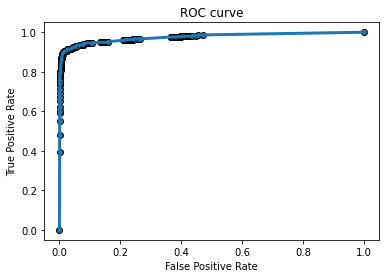

In [51]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, edgecolors='k',lw= 1)
plt.plot(fpr,tpr, lw=3)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [52]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score
print('ROC/AUC score = ',roc_auc_score(y_val, y_pred_proba))
print('F1 score = ',f1_score(y_val, y_pred))
print('Recall score = ',recall_score(y_val, y_pred))

ROC/AUC score =  0.9754350205277573
F1 score =  0.8969258589511754
Recall score =  0.8406779661016949


# XGBoost

In [60]:
from xgboost import XGBClassifier
model2 = XGBClassifier(n_estimators=51, random_state=13, n_jobs=-1)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred2))

Validation Accuracy 0.9823091247672253


In [57]:
#91 Estimators
print('This is a ' + str(accuracy_score(y_val, y_pred2)-(model.score(X_val, y_val))) + ' improvement on the first model.') 

This is a 0.0009310986964617962 improvement on the first model.


In [59]:
#71 estimators
print('This is a ' + str(accuracy_score(y_val, y_pred2)-(model.score(X_val, y_val))) + ' improvement on the first model.') 

This is a 0.0012414649286157653 improvement on the first model.


In [61]:
#51 estimators
print('This is a ' + str(accuracy_score(y_val, y_pred2)-(model.score(X_val, y_val))) + ' improvement on the first model.') 

This is a 0.0024829298572315306 improvement on the first model.


In [67]:
#31 estimators
print('This is a ' + str(accuracy_score(y_val, y_pred2)-(model.score(X_val, y_val))) + ' improvement on the first model.') 

This is a 0.0012414649286157653 improvement on the first model.


In [69]:
#41 estimators
print('This is a ' + str(accuracy_score(y_val, y_pred2)-(model.score(X_val, y_val))) + ' improvement on the first model.') 

This is a 0.0015518311607697344 improvement on the first model.


In [75]:
#49 Estimators
print('This is a ' + str(accuracy_score(y_val, y_pred2)-(model.score(X_val, y_val))) + ' improvement on the first model.') 

This is a 0.0021725636250775615 improvement on the first model.


In [25]:
#53 estimators
print('This is a ' + str(accuracy_score(y_val, y_pred2)-(model.score(X_val, y_val))) + ' improvement on the first model.') 

This is a 0.0024829298572315306 improvement on the first model.


### Tuning my hyperparameters lands me on 51 estimators being the least number (that tied 52 and 53) for the highest accuracy improvement. .2% is a pretty good improvement considering I only have 1.8% left before achieving a perfectly accurate model. Now to see how both models perform on the test set!

In [62]:
y_pred3 = model2.predict(X_test)
print('Testing accuracy using Random Forrest Regressor = ', model0.score(X_test, y_test))
print('Testing accuracy using Random Forrest Classifier = ', model.score(X_test, y_test))
print('Testing accuracy using XGBoost = ',accuracy_score(y_test, y_pred3))

Testing accuracy using Random Forrest Regressor =  0.7627017333383153
Testing accuracy using Random Forrest Classifier =  0.976536312849162
Testing accuracy using XGBoost =  0.9793296089385475


# Visualizations to explain my models performance

In [40]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist(),highlight_spaces=False)

Weight,Feature
0.1207 ± 0.0063,Excess kurtosis of the integrated profile
0.0021 ± 0.0007,Standard deviation of the DM-SNR curve
0.0009 ± 0.0009,Standard deviation of the integrated profile
0.0006 ± 0.0013,Skewness of the integrated profile
0.0006 ± 0.0011,Mean of the integrated profile
0.0001 ± 0.0015,Mean of the DM-SNR curve
-0.0001 ± 0.0008,Excess kurtosis of the DM-SNR curve
-0.0002 ± 0.0002,Skewness of the DM-SNR curve


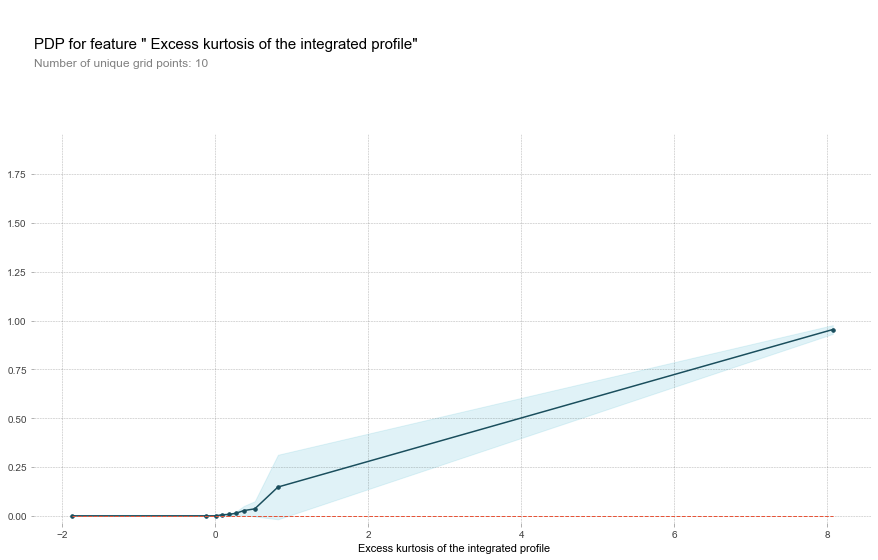

In [79]:
data = pd.DataFrame(X_train, columns = X_train.columns)
feat2plot = ' Excess kurtosis of the integrated profile' #feature to plot 
isolated = pdp_isolate(
    model=model2,
    dataset=data,
    model_features=X_test.columns,
    feature=feat2plot)
pdp_plot(isolated,
         feature_name=feat2plot);

Index([' Mean of the integrated profile',
       ' Standard deviation of the integrated profile',
       ' Excess kurtosis of the integrated profile',
       ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Standard deviation of the DM-SNR curve',
       ' Excess kurtosis of the DM-SNR curve',
       ' Skewness of the DM-SNR curve'],
      dtype='object')

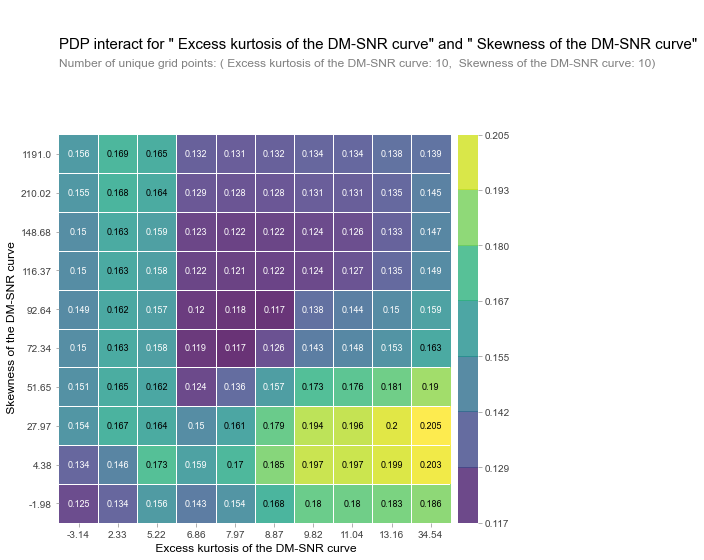

In [81]:
features = [' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve']
interaction = pdp_interact(
    model=model, 
    dataset=data, 
    model_features=X_train.columns, 
    features=features 
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);
plt.show()

In [72]:
row = X_test.iloc[[42]]
explainer = shap.TreeExplainer(model)
row_processed = row
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0], 
    features=row, 
    link='logit' 
)

 # Notes 

While the term 'pulsar' is a combination of the words 'pulse' and 'star, pulsars aren't pulsating and also aren't really stars (anymore).
     Thier emissions are continuous but beamed, so from any one perspective, a pulse of radiation is observered each time the beeam sweeps through the observers point of view. These sweeps are extremely regular in interval since they occur with each rotation of the pulsar.
     Think of the interstellar medium (ISM) as the 'space between' stars or even galaxies, the gases or empty space that exist not apparent to the naked eye or even optical telescopes. This space does have, at very least, electrons and other sub atomic particles detectable by our more powerful telescopes that work outside the optical spectrum. If you are to envision the ISM as an ocean rather than a void, it becomes easier to understand how pulsar stars are detected. The Dispersion Measure, refered to as DM in the data used in this article.

Citations:

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656

DOI of the data set:

R. J. Lyon, HTRU2, DOI: 10.6084/m9.figshare.3080389.v1.

Acknowledgements

This data was obtained with the support of grant EP/I028099/1 for the University of Manchester Centre for Doctoral Training in Computer Science, from the UK Engineering and Physical Sciences Research Council (EPSRC). The raw observational data was collected by the High Time Resolution Universe Collaboration using the Parkes Observatory, funded by the Commonwealth of Australia and managed by the CSIRO.

Additional information sources:

[SPINN: a straightforward machine learning solution to the pulsar candidate selection problem](https://academic.oup.com/mnras/article/443/2/1651/1058949)

[Selection of radio pulsar candidates using artificial neural networks](http://old.inspirehep.net/record/856422/plots?ln=en)

[Introduction to Pulsar, Pulsar Timing, and
measuring of Pulse Time-of-Arrivals](http://ipta.phys.wvu.edu/files/student-week-2017/IPTA2017_KuoLiu_pulsartiming.pdf)

[A Pulsar.  (left or top):  A diagram of the traditional magnetic dipole model of a pulsar. ](https://www.cv.nrao.edu/course/astr534/Pulsars.html)